In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder


from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold,GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn import linear_model, metrics
import shap

from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
import joblib

import warnings
warnings.filterwarnings('ignore')


In [4]:
df=pd.read_csv(r'C:\Users\Mohamed\Desktop\MGP\PJT2SEP\train_dataset.csv')
cdf=df.copy()
df.shape

(75757, 64)

In [90]:
pd.set_option("max_columns", 64)
df.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

### Changing the columns names to lower case

In [5]:
def columnNameToLowercase(dataFrame):
    dataFrame.rename(columns={
        'Year_Factor': 'year_factor', 
        'State_Factor': 'state_factor',
        'ELEVATION': 'elevation',
        }, inplace=True)
    return dataFrame

df=columnNameToLowercase(df)


## Understanding features

***Each building id has the site_eui mentioned for different configurations of columns.***


**year_Factor**: anonymized year in which the weather and energy usage factors were observed  

**state_Factor**: anonymized state in which the building is located  

**building_class**: building classification  

**facility_type**: building usage type  

**floor_area**: floor area (in square feet) of the building  

**year_built**: year in which the building was constructed  

**energy_star_rating**: the energy star rating of the building  

**elevation**: elevation of the building location  

**january_min_temp**: minimum temperature in January (in Fahrenheit) at the location of the building  

**january_avg_temp**: average temperature in January (in Fahrenheit) at the location of the building  

**january_max_temp**: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

**cooling_degree_days**: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.Cooling degree days (CDD) are a measure of how hot the temperature was on a given day or during a period of days.  

**heating_degree_days**: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

**precipitation_inches**: annual precipitation in inches at the location of the building  

**snowfall_inches**: annual snowfall in inches at the location of the building  

**snowdepth_inches**: annual snow depth in inches at the location of the building  

**avg_temp**: average temperature over a year at the location of the building  

**days_below_30F**: total number of days below 30 degrees Fahrenheit at the location of the building  

**days_below_20F**: total number of days below 20 degrees Fahrenheit at the location of the building  

**days_below_10F**: total number of days below 10 degrees Fahrenheit at the location of the building  

**days_below_0F**: total number of days below 0 degrees Fahrenheit at the location of the building  

**days_above_80F**: total number of days above 80 degrees Fahrenheit at the location of the building  

**days_above_90F**: total number of days above 90 degrees Fahrenheit at the location of the building  

**days_above_100F**: total number of days above 100 degrees Fahrenheit at the location of the building  

**days_above_110F**: total number of days above 110 degrees Fahrenheit at the location of the building  

**direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

**max_wind_speed**: maximum wind speed at the location of the building  

**days_with_fog**: number of days with fog at the location of the building  

**building_id**: building id  

### Target
**site_eui**: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills  

In [93]:
df.describe()

,year_factor,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,building_id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,21.606281,44.469292,70.897831,32.037171,53.784863,82.661932,44.706179,63.742547,88.987856,51.131763,71.066384,91.400280,60.571604,76.596879,95.543950,58.515068,75.348749,92.572581,50.791689,69.597545,92.171139,38.210911,58.727038,81.135671,28.630397,48.123133,71.202397,22.736777,41.625569,64.496852,1202.250446,4324.957390,42.430651,29.136379,164.862455,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,10.004303,6.657142,7.680982,5.577279,2.500473,4.101028,4.200319,2.792919,2.864669,3.415926,2.861681,3.604068,4.177109,4.090275,4.157118,4.441992,3.818895,4.139685,4.290884,3.603773,5.011708,5.093899,2.641300,5.579513,7.153244,4.094207,4.373374,9.014047,5.869386,6.054104,391.561780,824.366727,10.592205,17.810894,175.275869,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,62.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,13.000000,38.096774,62.000000,26.000000,52.333333,80.000000,42.000000,62.790323,88.000000,50.000000,70.983333,89.000000,57.000000,76.145161,95.000000,57.000000,74.516129,90.000000,47.000000,68.200000,91.000000,35.000000,58.048387,78.000000,23.000000,45.250000,69.000000,17.000000,38.532258,60.000000,1128.00

In [94]:
df.describe(include ='object').T

,count,unique,top,freq
state_factor,75757,7,State_6,50840
building_class,75757,2,Residential,43558
facility_type,75757,60,Multifamily_Uncategorized,39455


In [11]:
for col in df.columns:
    print(df[col].value_counts())
    print("\n")

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: year_factor, dtype: int64


State_6     50840
State_11     6412
State_1      5618
State_2      4871
State_4      4300
State_8      3701
State_10       15
Name: state_factor, dtype: int64


Residential    43558
Commercial     32199
Name: building_class, dtype: int64


Multifamily_Uncategorized                    39455
Office_Uncategorized                         12512
Education_Other_classroom                     3860
Lodging_Hotel                                 2098
2to4_Unit_Building                            1893
Commercial_Other                              1744
5plus_Unit_Building                           1273
Warehouse_Nonrefrigerated                     1255
Retail_Uncategorized                          1130
Education_College_or_university               1056
Nursing_Home                                   772
Education_Uncategorized                        709
Mixed_Use_Commercial_and_Residential           6

Name: december_max_temp, dtype: int64


1489    13015
1581    10144
1128     9267
1277     8362
1272     8296
        ...  
1435        1
2010        1
1370        1
1369        1
0           1
Name: cooling_degree_days, Length: 162, dtype: int64


4252    13015
4460    10144
4875     9267
3978     8362
4670     8296
        ...  
1898        1
6071        1
1834        1
6889        1
5211        1
Name: heating_degree_days, Length: 170, dtype: int64


42.17    13015
40.97    10144
53.79     9267
38.51     8362
46.32     8296
         ...  
77.19        1
13.54        1
29.97        1
49.01        1
2.81         1
Name: precipitation_inches, Length: 171, dtype: int64


36.0    13015
49.1    10144
50.0     9267
0.0      8726
9.6      8363
        ...  
54.9        1
0.5         1
3.0         1
11.5        1
59.3        1
Name: snowfall_inches, Length: 71, dtype: int64


101     13015
463     10144
377      9269
0        8740
10       8363
64       8296
1        3214
154      2121
418  

### Viz 1: Categorical columns

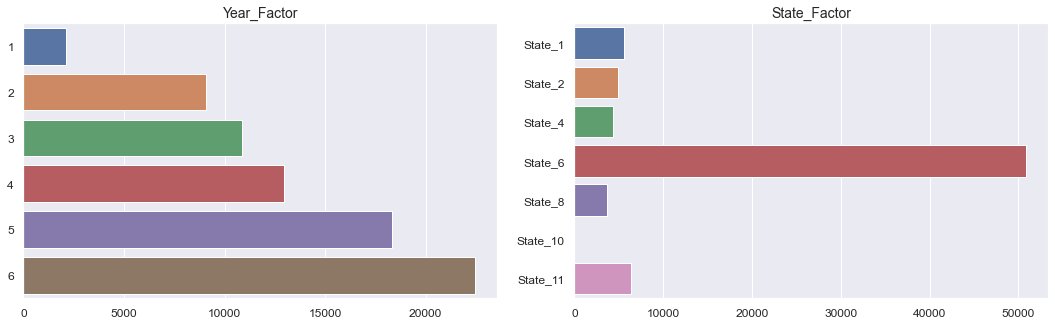

In [248]:
colviz=['year_factor','state_factor']
plt.figure(figsize=(15,70))
plotnumber = 1

for col in colviz:
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col)
        sns.color_palette("Set2")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

### Observation:

* Year on year from 1-6 ,the data points are increasing.
* State 6 has more data points compared to other states.
* Residential building data points are more comapred to commercial.


### Viz 2: site_eui plot ----target column

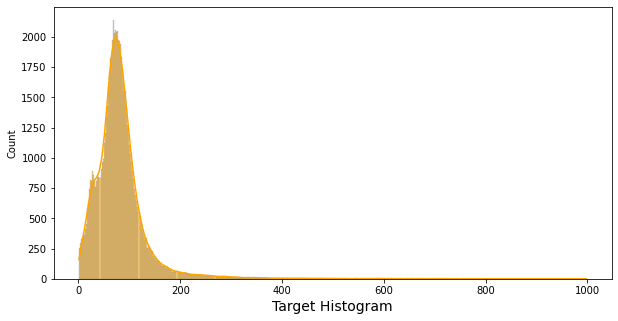

In [96]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,1,1)
sns.histplot(x=df['site_eui'],kde=True,palette='Deep',color='orange')
ax1.set_xlabel('Target Histogram', fontsize=14)
plt.show()

In [97]:
print("{0:<25} : {1:<25}  : {2:<15}".format("Column Name","Max element","Least Frequent"))
print("___________________________________________________________________________________")

for col in df.columns:
    print("{0:<25} : {1:<25}  : {2:<15}".format(col,df[col].max(),df[col].min()))
    

Column Name               : Max element                : Least Frequent 
___________________________________________________________________________________
year_factor               : 6                          : 1              
state_factor              : State_8                    : State_1        
building_class            : Residential                : Commercial     
facility_type             : Warehouse_Uncategorized    : 2to4_Unit_Building
floor_area                : 6385382.0                  : 943.0          
year_built                : 2015.0                     : 0.0            
energy_star_rating        : 100.0                      : 0.0            
elevation                 : 1924.5                     : -6.4           
january_min_temp          : 49                         : -19            
january_avg_temp          : 64.75806452                : 10.80645161    
january_max_temp          : 91                         : 42             
february_min_temp         : 48       

### Viz 3:site_eui vs Building class distribution 

<AxesSubplot:xlabel='building_class', ylabel='count'>

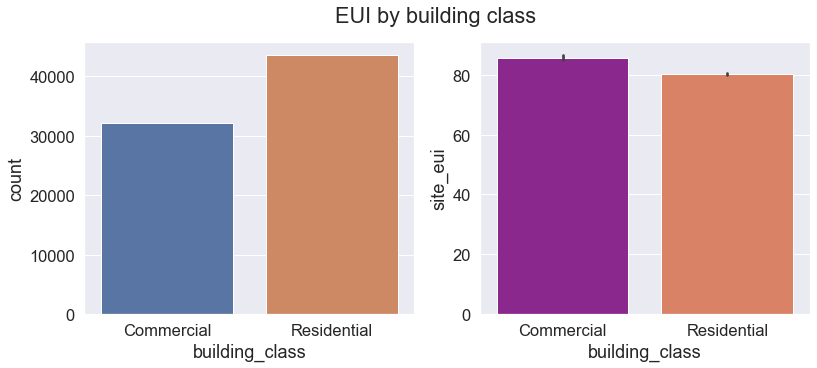

In [247]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
fig.suptitle("EUI by building class")
plt.subplots_adjust(hspace = 0.8)
sns.barplot(x ='building_class', y ='site_eui', data = df,palette ='plasma',ax=ax[1])
#sns.countplot(data=df,x='building_class',ax=ax[1])
sns.countplot(x ='building_class',data = df,ax=ax[0])

### Observation:
  * Count plot shows more data points for residential than commercial building.
  * Site eui describes commercial has more consumption than residential.

### Viz 4: site eui vs cooling/heating/snowfall/precipitation/avg temp for commercial and residential building

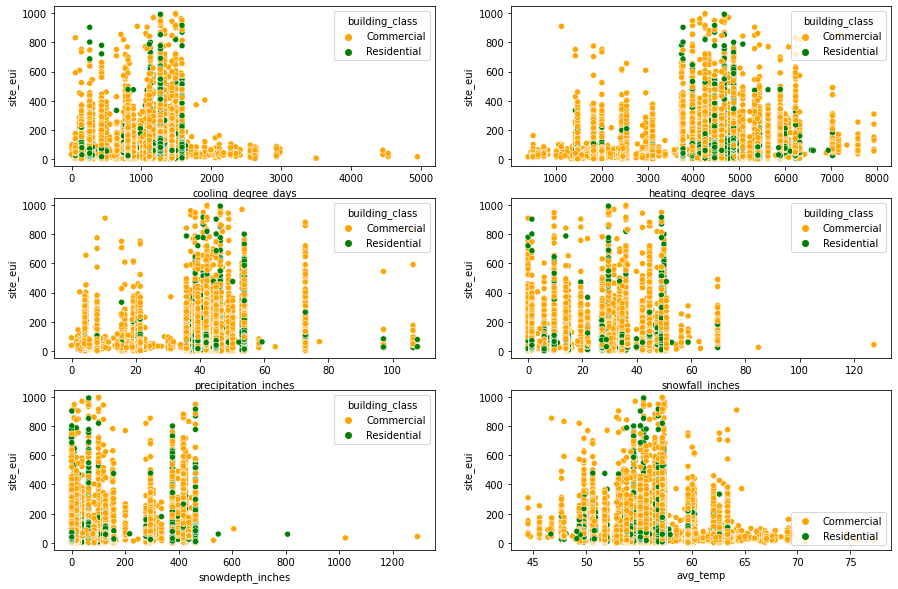

In [98]:
fig, ax = plt.subplots(3, 2, figsize=(15,10) )
for variable, subplot in zip(df.columns[44:52], ax.flatten()):
    sns.scatterplot(x=variable,y="site_eui", hue="building_class",
                    data=df,ax=subplot,
                    palette=dict(Commercial="orange", Residential="green") )   
plt.legend(loc='lower right')
plt.show()

### Observation:
**Cooling degree days** :Commercial building has more CDD than Residential building.When CDD is within 1600 days,site_eui has gone up till 1000 units.When CDD is more than 1600,Site eui is less than 200.

**Heating degree days** :When HDD is between 3800 and 6200,site eui has goneup till 1000 units.The distribution of data conveys about commerical building being the major consumer.

**Precipitation inches**:When PI was between 38 and 55,site eui consumption has gone up till 1000 units.

**Snawfall inches** : site eui has gone up to 1000 when SI was between 0 and 70. Nothing beyond.

**Snow depth inches** : When SDI was between 0 and 190 /380 and 450 inches ,site eui has gone up to 1000 units.

**avg temp** :When avg temp was between 53 and 58,site eui has gone up to 1000 units.

### Viz 5: site eui vs (Elevation, floor area and year built)

<AxesSubplot:xlabel='year_built', ylabel='site_eui'>

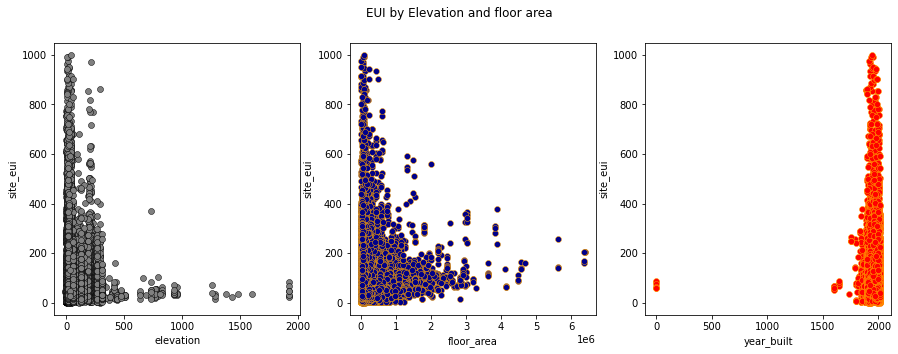

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("EUI by Elevation and floor area")
plt.subplots_adjust(hspace = 0.8)
sns.scatterplot(x='elevation',y='site_eui',data=df,color='gray',ax=ax[0],edgecolor ='black')
sns.scatterplot(x='floor_area',y='site_eui',data=df,color='darkblue',ax=ax[1],edgecolor ='orange')
sns.scatterplot(x='year_built',y='site_eui',data=df,color='red',ax=ax[2],edgecolor ='orange')


### Observation :
* Elevation:When elevation has gone more than 500,site eui is can be seen an outliers.Smaller the elevation higher the eui.
* smaller the floor area higher the eui.
* building in the year 1900and 2000 consume more eui compared to building built in the  year.(Could be high raised buildingand material quality)



###  Viz 6 :Site eui vs energy star rating

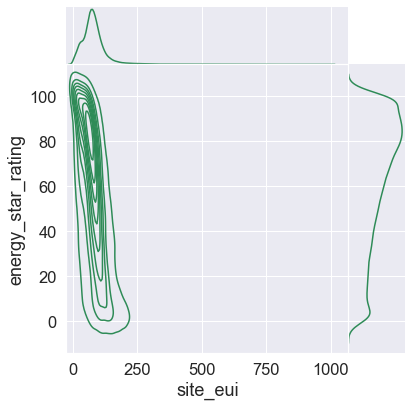

In [202]:
sns.jointplot(x='site_eui',y='energy_star_rating',data=df,color='seagreen', kind = "kde",space=0)

### Observation:
* Higher the energy star rating lower the site_eui

### Viz 7: site _eui in states

<AxesSubplot:ylabel='site_eui'>

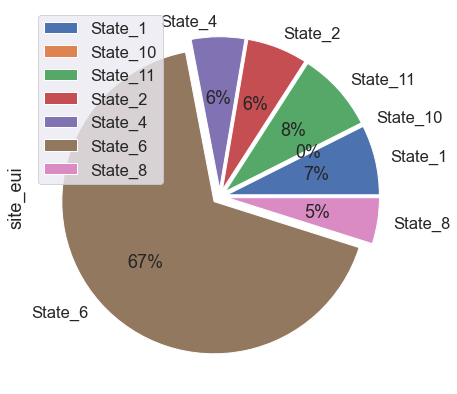

In [176]:
# Define the ratio of gap of each fragment in a tuple
explode = (0.05, 0.05, 0.05,0.05, 0.05, 0.05,0.05)
  
# Plotting the pie chart for above dataframe
df.groupby(['state_factor']).count().plot(kind='pie', y='site_eui', autopct='%1.0f%%', explode=explode,figsize=(6, 6))


### Observation:
* State 6 is the major state who consumed more eui. 
* State 10 least consumption.


### Viz 8: Box plot of facility type

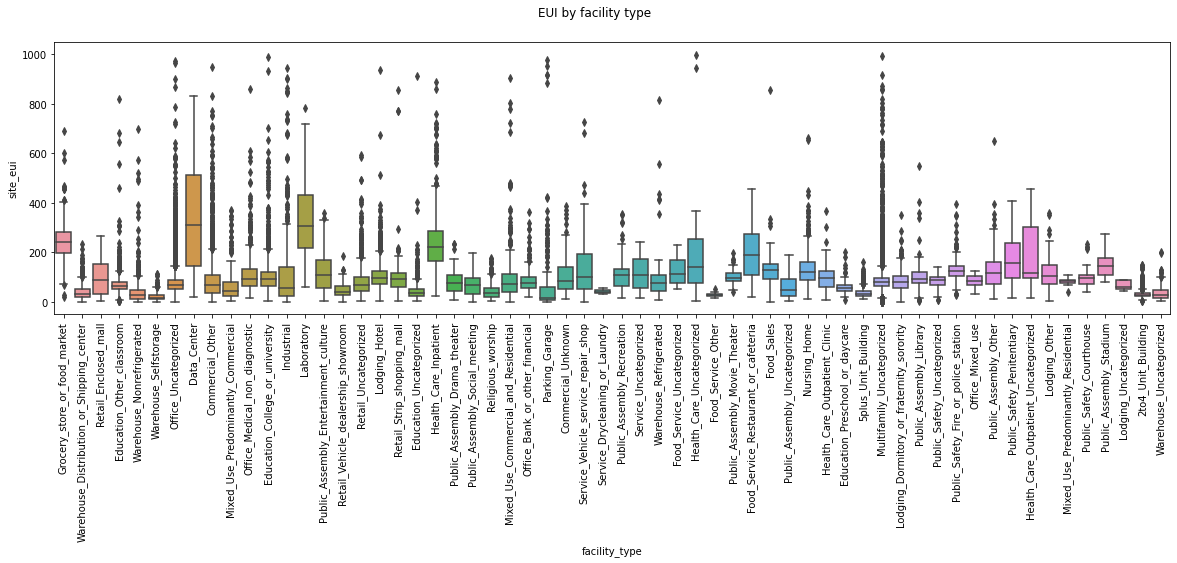

In [105]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Observation:

* Data center has maximum site eui consumption followed by Laboratory.



### Viz 9: Site eui vs direction of max wind speed/peak wind speed /days with fog

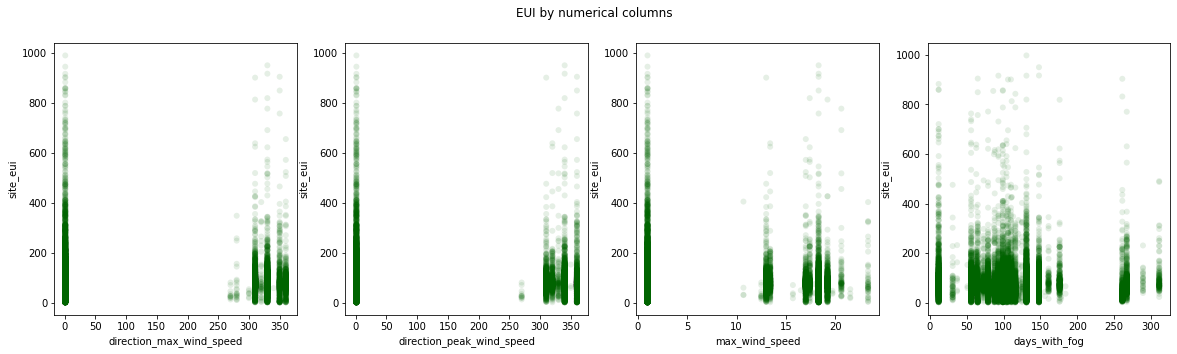

In [108]:
cols=['direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed','days_with_fog']

fig, ax = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('EUI by numerical columns')

for variable, subplot in zip(cols, ax.flatten()):
    sns.scatterplot(x=variable,y="site_eui",data=df,ax=subplot,color='darkgreen',edgecolor ='none',alpha = .1)  

plt.show()
      


### Observation:

* When direction max wind speed & peak wind speed were around 300-350,site eui consumption was around 200 units and nothing between 10 -250.
* when days with fog were between 180 and 250,no site eui was observed. 


### Viz 10 : Distribution of temp across all the months

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


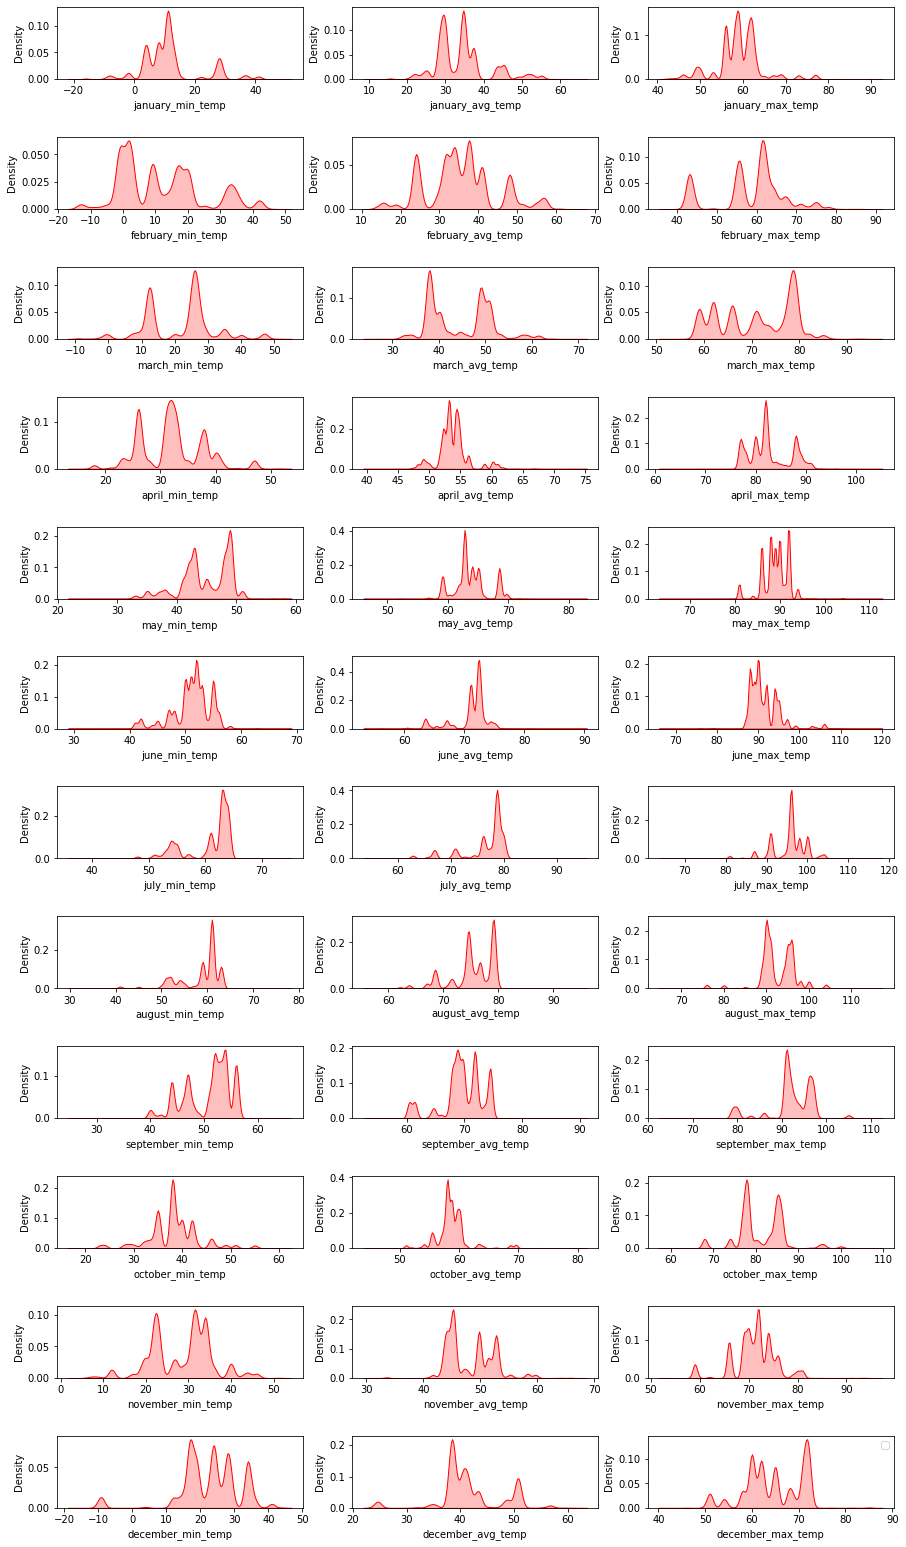

In [109]:
temp_features=df.columns[8:44]
plt.figure(figsize =(15,30))
for i in enumerate(temp_features):
    plt.subplot(13,3,i[0]+1)
    sns.kdeplot(df[i[1]], shade=True, color="r")
    plt.subplots_adjust(hspace = 0.8)
plt.legend()
    

### Observation:
* Jun.July,August and September -the Avg temp was between 60-80 Farenhit ,Max temp between 90-100. 


### Preprocessing

In [110]:
df.isna().sum()[df.isna().sum()!=0]

year_built                    1837
energy_star_rating           26709
direction_max_wind_speed     41082
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
dtype: int64

### Missing values

In [111]:
# Total missing values by column
mis_val = df.isnull().sum()

# Percentage of missing values by column
mis_val_percent = 100 * df.isnull().sum() / len(df)

# build a table with the thw columns
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

mis_col_rename=mis_val_table.rename(columns={0:"Missing Value",1: "% of Missing value"})

missing_table=mis_col_rename[mis_col_rename.iloc[:,1]!=0].sort_values('% of Missing value',ascending=False).round(2)
missing_table

,Missing Value,% of Missing value
days_with_fog,45796,60.45
direction_peak_wind_speed,41811,55.19
direction_max_wind_speed,41082,54.23
max_wind_speed,41082,54.23
energy_star_rating,26709,35.26
year_built,1837,2.42


In [112]:
# Removing the  
catcol=df.loc[:,df.dtypes=='object']
df.drop(['state_factor', 'building_class', 'facility_type','id','site_eui'],axis=1,inplace=True)

In [102]:
knn_imputing =False
if knn_imputing:
    imputer = KNNImputer(n_neighbors=7, weights='uniform', metric='nan_euclidean')
    imputer.fit(df)
    # transform the dataset
    Xtrans = imputer.transform(df) 
    df_imp=pd.DataFrame(Xtrans,columns=df.columns)
    df_imp.to_csv('df_imputed.csv',index=False) # saving this because knn imputing takes nearly one hour.

In [113]:
# loading the imputed csv file
df_imp=pd.read_csv('df_imputed.csv')

### Viz 11 :Heat map of all the variables

<AxesSubplot:>

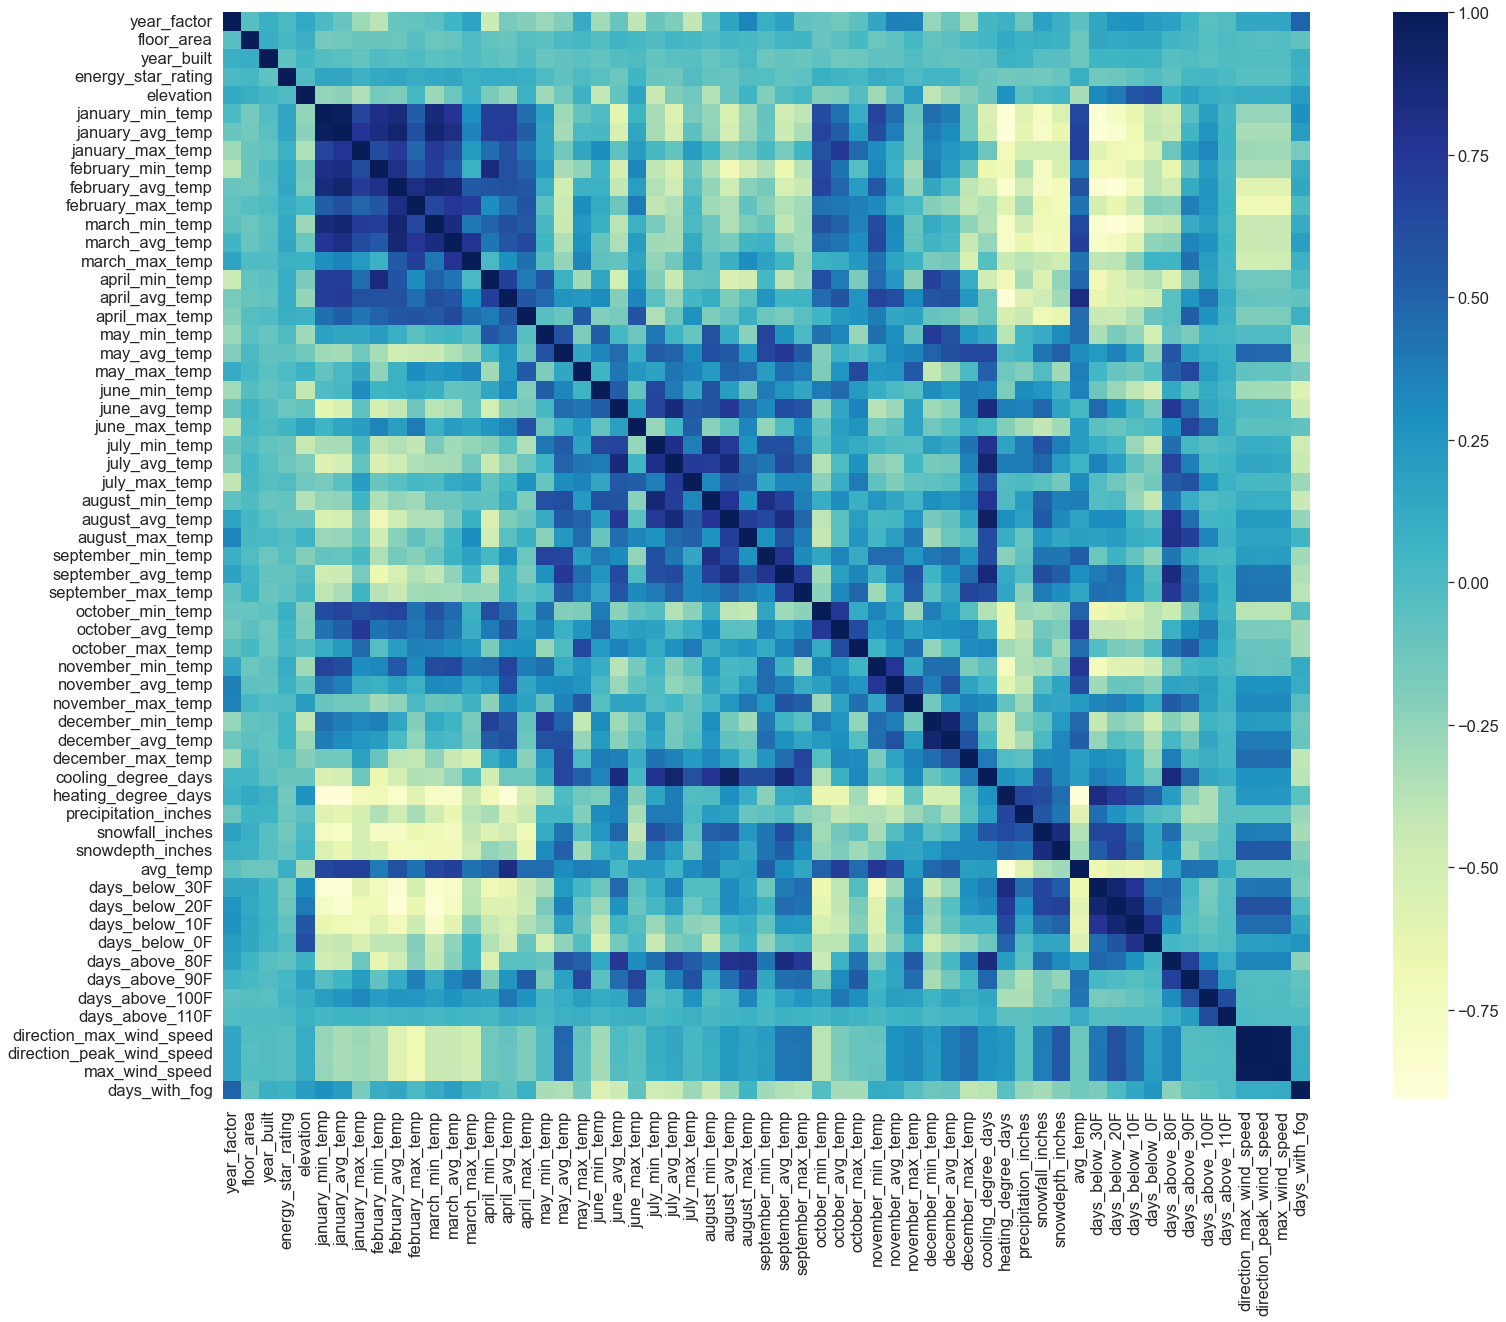

In [114]:
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.heatmap(df_imp.corr(),cmap="YlGnBu",square=True)

### Observation:
* Day above 80F has positive correlation to cooling degree days.
* Cooling degree days has positive correlation with May,Jun,july,aug temperatures.

### Approach 1 with given dataset(Dropping 'id' column only).

### Normalising the data

In [117]:
#Applying MinMaxScaler on numerical columns
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_imp)
minMaxdf = pd.DataFrame(x_scaled,columns=df_imp.columns)

In [118]:
#Applying label encode for categorical columns.
catdf = catcol.apply(LabelEncoder().fit_transform)

In [119]:
#Preparing train dataset by combining min Max scaler with label encoded categorical columns 
X_train=minMaxdf.join(catdf)
Y_train=cdf['site_eui']


In [120]:
X_train.shape

(75757, 62)

### Preparing test data

In [128]:
xtest=pd.read_csv(r'C:\Users\Mohamed\Desktop\MGP\PJT2SEP\x_test.csv')
ytest=pd.read_csv(r'C:\Users\Mohamed\Desktop\MGP\PJT2SEP\Y_test.csv')

In [122]:
xtest.shape

(9705, 63)

In [129]:
#X_test preparation- Renaming the columns

xtest.rename(columns={
        'Year_Factor': 'year_factor', 
        'State_Factor': 'state_factor',
        'ELEVATION': 'elevation',
        
    }, inplace=True)
#Dropping id column
xtest.drop(['id'],axis=1,inplace=True)
#Checking if Missing values in test set.
for col in xtest.columns:
    # count number of rows with missing values
    n_miss = xtest[col].isnull().sum()
    perc = n_miss / xtest.shape[0] * 100
    if n_miss == 0.00:
        continue
    print('> %s, Missing: %d (%.1f%%)' % (col, n_miss, perc))


> year_built, Missing: 92 (0.9%)
> energy_star_rating, Missing: 2254 (23.2%)
> direction_max_wind_speed, Missing: 8575 (88.4%)
> direction_peak_wind_speed, Missing: 8575 (88.4%)
> max_wind_speed, Missing: 8575 (88.4%)
> days_with_fog, Missing: 9117 (93.9%)


In [130]:
#Removing catergorical columns from xtest
catcolx=xtest.loc[:,xtest.dtypes=='object']

#dropping cat col from xtest so that knn imputing can be done for numerical columns
xtest.drop(catcolx,axis=1,inplace=True)    

#Imputing with KNN imputer
ximputer = KNNImputer(n_neighbors=7, weights='uniform', metric='nan_euclidean')
ximputer.fit(xtest)
Xtest_trans = ximputer.transform(xtest) 
#converting numpy array into dataframe
xtest_imp=pd.DataFrame(Xtest_trans,columns=xtest.columns)
#xtest_imp=catxdf.join(xtest_imp)

In [131]:
#Scaling the values
min_max_scaler = MinMaxScaler()
xtest_scaled = min_max_scaler.fit_transform(xtest_imp)
xminMaxdf = pd.DataFrame(xtest_scaled,columns=xtest_imp.columns)
#Label encoding categorical columns
catxdf = catcolx.apply(LabelEncoder().fit_transform)
#combining categorical with minmax df
Xtest=xminMaxdf.join(catxdf)

In [126]:
Xtest.shape

(9705, 62)

In [132]:
ytest.drop(['id'],axis=1,inplace=True)
ytest.isna().sum()

site_eui    0
dtype: int64

### Base line Modeling 

### XGBoost

In [133]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, Y_train)
y_pred = xgb.predict(Xtest)

In [134]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(ytest,y_pred)))
print(" MAE:", mean_absolute_error(ytest,y_pred))
print(" MSE:", mean_squared_error(ytest,y_pred))
print(" R2:", r2_score(ytest,y_pred))

 Training data scores
 --------------------
 RMSE: 131.2136051557318
 MAE: 82.38502993507517
 MSE: 17217.01017796429
 R2: -3.761765981820176


In [135]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, Y_train)
y_pred = rf.predict(Xtest)

In [136]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(ytest,y_pred)))
print(" MAE:", mean_absolute_error(ytest,y_pred))
print(" MSE:", mean_squared_error(ytest,y_pred))
print(" R2:", r2_score(ytest,y_pred))

 Training data scores
 --------------------
 RMSE: 89.99043719658268
 MAE: 55.813513927126394
 MSE: 8098.278786832091
 R2: -1.2397679991958128


### Catboost

In [137]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [138]:
cats_discrete_idx = np.where(X_train.dtypes != 'float64')[0]
catb.fit(X_train, Y_train,
                 eval_set=(Xtest,ytest),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(Xtest)

0:	learn: 57.8686099	test: 60.7025391	best: 60.7025391 (0)	total: 1.24s	remaining: 10m 20s
75:	learn: 45.6519774	test: 46.8604590	best: 46.8604590 (75)	total: 1m 3s	remaining: 5m 54s
150:	learn: 42.7683143	test: 44.0794254	best: 44.0794254 (150)	total: 2m 2s	remaining: 4m 43s
225:	learn: 41.5644942	test: 43.5900388	best: 43.5734255 (221)	total: 3m 1s	remaining: 3m 40s
300:	learn: 40.8337814	test: 43.4453337	best: 43.3786069 (274)	total: 3m 59s	remaining: 2m 38s
375:	learn: 40.2538144	test: 43.3653107	best: 43.3537164 (371)	total: 4m 56s	remaining: 1m 37s
450:	learn: 39.7801761	test: 43.4056204	best: 43.3474069 (398)	total: 5m 53s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 43.34740688
bestIteration = 398

Shrink model to first 399 iterations.


In [139]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(ytest,y_pred)))
print(" MAE:", mean_absolute_error(ytest,y_pred))
print(" MSE:", mean_squared_error(ytest,y_pred))
print(" R2:", r2_score(ytest,y_pred))

 Training data scores
 --------------------
 RMSE: 43.34740692234315
 MAE: 24.91147514962893
 MSE: 1878.9976868912024
 R2: 0.48031933693058626


# Hyperparameter Tuning


### Using CrossValidation on CatBoost

In [46]:
from tqdm.notebook import tqdm_notebook
import time

In [73]:
Y_train.shape
copyX_train=X_train
copyY_train=Y_train

In [140]:
# prepaere the out of folds predictions 
train=X_train
target=Y_train

train_oof = np.zeros((X_train.shape[0],))
test_preds = np.zeros(Xtest.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm_notebook(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][Xtest.columns], train.iloc[test_idx][Xtest.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    model=catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = model.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += model.predict(Xtest)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]

0:	learn: 57.4073232	test: 59.7337608	best: 59.7337608 (0)	total: 840ms	remaining: 6m 58s
75:	learn: 45.6044577	test: 48.2217232	best: 48.2217232 (75)	total: 56.6s	remaining: 5m 15s
150:	learn: 42.7763056	test: 46.2476566	best: 46.2476566 (150)	total: 1m 51s	remaining: 4m 17s
225:	learn: 41.5263796	test: 45.6907816	best: 45.6907816 (225)	total: 2m 46s	remaining: 3m 22s
300:	learn: 40.7177156	test: 45.4318677	best: 45.4318677 (300)	total: 3m 41s	remaining: 2m 26s
375:	learn: 40.0670490	test: 45.2199977	best: 45.2199977 (375)	total: 4m 35s	remaining: 1m 30s
450:	learn: 39.5707560	test: 45.0807526	best: 45.0807526 (450)	total: 5m 32s	remaining: 36.1s
499:	learn: 39.1866788	test: 44.9906659	best: 44.9903663 (498)	total: 6m 9s	remaining: 0us

bestTest = 44.99036631
bestIteration = 498

Shrink model to first 499 iterations.
out-of-folds prdiction ==== fold_0 RMSE 6.707485839930723


0:	learn: 57.9790785	test: 57.4281901	best: 57.4281901 (0)	total: 1.88s	remaining: 15m 35s
75:	learn: 45.6175756	test: 46.1504068	best: 46.1504068 (75)	total: 59.8s	remaining: 5m 33s
150:	learn: 42.8012240	test: 44.4516027	best: 44.4516027 (150)	total: 1m 55s	remaining: 4m 26s
225:	learn: 41.4592625	test: 44.0142930	best: 44.0142930 (225)	total: 2m 50s	remaining: 3m 26s
300:	learn: 40.6046402	test: 43.8107607	best: 43.8100840 (298)	total: 3m 46s	remaining: 2m 29s
375:	learn: 39.9398856	test: 43.6777493	best: 43.6773031 (374)	total: 4m 41s	remaining: 1m 32s
450:	learn: 39.3849786	test: 43.6080714	best: 43.6080714 (450)	total: 5m 37s	remaining: 36.7s
499:	learn: 39.0367397	test: 43.5699181	best: 43.5699181 (499)	total: 6m 13s	remaining: 0us

bestTest = 43.56991809
bestIteration = 499

out-of-folds prdiction ==== fold_1 RMSE 6.600751315545381


0:	learn: 58.0383770	test: 57.2608923	best: 57.2608923 (0)	total: 793ms	remaining: 6m 35s
75:	learn: 45.7671254	test: 46.1791635	best: 46.1791635 (75)	total: 56s	remaining: 5m 12s
150:	learn: 42.8088350	test: 44.4135811	best: 44.4135811 (150)	total: 1m 51s	remaining: 4m 18s
225:	learn: 41.4324436	test: 43.9894302	best: 43.9894302 (225)	total: 2m 48s	remaining: 3m 23s
300:	learn: 40.5596835	test: 43.7747249	best: 43.7747249 (300)	total: 3m 44s	remaining: 2m 28s
375:	learn: 39.8838540	test: 43.6295064	best: 43.6293610 (374)	total: 4m 41s	remaining: 1m 32s
450:	learn: 39.3365428	test: 43.5383559	best: 43.5372598 (446)	total: 5m 35s	remaining: 36.5s
499:	learn: 38.9567590	test: 43.4467177	best: 43.4467177 (499)	total: 6m 11s	remaining: 0us

bestTest = 43.44671768
bestIteration = 499

out-of-folds prdiction ==== fold_2 RMSE 6.59141242569582


0:	learn: 57.9271684	test: 57.7088986	best: 57.7088986 (0)	total: 845ms	remaining: 7m 1s
75:	learn: 45.7089651	test: 46.6282794	best: 46.6282794 (75)	total: 57.3s	remaining: 5m 19s
150:	learn: 42.6351740	test: 44.8199114	best: 44.8199114 (150)	total: 1m 53s	remaining: 4m 22s
225:	learn: 41.2943702	test: 44.3716241	best: 44.3716241 (225)	total: 2m 48s	remaining: 3m 24s
300:	learn: 40.3464320	test: 44.1355766	best: 44.1355766 (300)	total: 3m 45s	remaining: 2m 28s
375:	learn: 39.6228104	test: 44.0188791	best: 44.0188791 (375)	total: 4m 40s	remaining: 1m 32s
450:	learn: 38.9896570	test: 43.8852162	best: 43.8843695 (449)	total: 5m 34s	remaining: 36.3s
499:	learn: 38.6414499	test: 43.8273081	best: 43.8264738 (497)	total: 6m 9s	remaining: 0us

bestTest = 43.82647382
bestIteration = 497

Shrink model to first 498 iterations.
out-of-folds prdiction ==== fold_3 RMSE 6.620156630664833


0:	learn: 58.0362779	test: 57.2626761	best: 57.2626761 (0)	total: 773ms	remaining: 6m 25s
75:	learn: 45.5481790	test: 46.3892269	best: 46.3892269 (75)	total: 56.4s	remaining: 5m 14s
150:	learn: 42.6185675	test: 44.7052832	best: 44.7052832 (150)	total: 1m 55s	remaining: 4m 26s
225:	learn: 41.2633073	test: 44.2225142	best: 44.2225142 (225)	total: 2m 52s	remaining: 3m 28s
300:	learn: 40.3966321	test: 44.0265747	best: 44.0265747 (300)	total: 3m 49s	remaining: 2m 31s
375:	learn: 39.6731100	test: 43.8997799	best: 43.8997799 (375)	total: 4m 45s	remaining: 1m 34s
450:	learn: 39.0942386	test: 43.7957737	best: 43.7957680 (448)	total: 5m 39s	remaining: 36.9s
499:	learn: 38.7458047	test: 43.7317429	best: 43.7317429 (499)	total: 6m 20s	remaining: 0us

bestTest = 43.73174295
bestIteration = 499

out-of-folds prdiction ==== fold_4 RMSE 6.612998036848511


Text(0.5, 0, 'iteration')

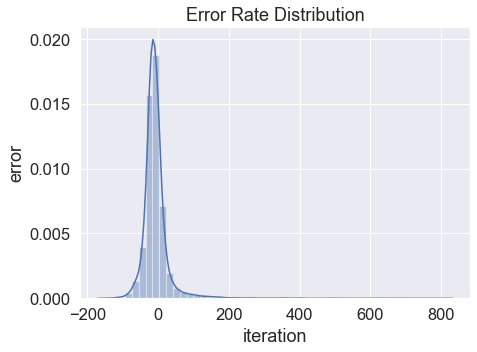

In [141]:
y_hat_tuned = catb.predict(Xtest)
y_hat_tuned  = pd.DataFrame(y_hat_tuned , columns = ['site_eui'])
plt.figure(figsize = (7,5))
sns.distplot(ytest - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### Optuna Tuning

In [142]:
X_train=copyX_train
Y_train=copyY_train
# Objective function
def random_forest_objective(trial, data=X_train, target=Y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [143]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [144]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2022-03-25 12:44:18,145] A new study created in memory with name: no-name-1f7aba4e-32ca-4641-afe7-3a1154013ae1
[I 2022-03-25 13:33:55,836] Trial 0 finished with value: -42.278939046501584 and parameters: {'n_estimators': 448, 'max_depth': 14, 'min_samples_split': 8, 'max_features': 0.8485406509615937}. Best is trial 0 with value: -42.278939046501584.


Best score: -42.278939046501584
Optimized parameters: {'n_estimators': 448, 'max_depth': 14, 'min_samples_split': 8, 'max_features': 0.8485406509615937}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: total: 49min 25s
Wall time: 49min 37s


In [146]:
rf_tuned_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=14, max_features=0.8485406509615937,
                      min_samples_split=8, n_estimators=448)

Text(0.5, 0, 'iteration')

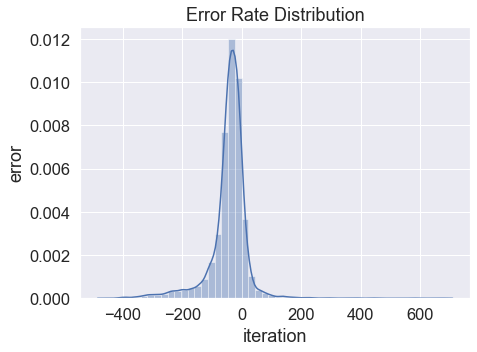

In [147]:
y_hat_tuned = rf_tuned_model.predict(Xtest)
y_hat_tuned  = pd.DataFrame(y_hat_tuned , columns = ['site_eui'])
plt.figure(figsize = (7,5))
sns.distplot(ytest - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

In [160]:
#Saving both the models
with open('model/rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('model/catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

## Approach 2 - Feature Engineering

In [152]:
def featureEngineering(fedf):
    catcolfe=fedf.loc[:,fedf.dtypes=='object']
    fedf.drop(catcolfe.columns,axis=1,inplace=True)
    imputer = KNNImputer(n_neighbors=7, weights='uniform', metric='nan_euclidean')
    imputer.fit(fedf)
    # transform the dataset
    Xtrans = imputer.transform(fedf) 
    df_imp=pd.DataFrame(Xtrans,columns=fedf.columns)
    
    #Feature engineering the monthly temp columns to seasonal temp columns and removing monthly temp columns.
    tempcol=[col for col in fedf.columns if 'temp' in col]
    del tempcol[-1]
    temp = pd.Series(tempcol)
    winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
    spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
    summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
    autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values
    df_FE=pd.DataFrame()
    ### winter
    df_FE['min_winter_temp'] = df_imp[winter_temp].min(axis=1)
    df_FE['max_winter_temp'] = df_imp[winter_temp].max(axis=1)
    df_FE['avg_winter_temp'] = df_imp[winter_temp].mean(axis=1)
    ### spring
    df_FE['min_spring_temp'] = df_imp[spring_temp].min(axis=1)
    df_FE['max_spring_temp'] = df_imp[spring_temp].max(axis=1)
    df_FE['avg_spring_temp'] = df_imp[spring_temp].mean(axis=1)
    ### summer
    df_FE['min_summer_temp'] = df_imp[summer_temp].min(axis=1)
    df_FE['max_summer_temp'] = df_imp[summer_temp].max(axis=1)
    df_FE['avg_summer_temp'] = df_imp[summer_temp].mean(axis=1)
    ## autumn
    df_FE['min_autumn_temp'] = df_imp[autumn_temp].min(axis=1)
    df_FE['max_autumn_temp'] = df_imp[autumn_temp].max(axis=1)
    df_FE['avg_autumn_temp'] = df_imp[autumn_temp].mean(axis=1)
    
    # Feature engineering on total area of the building
    df_FE['building_area'] = df_imp['floor_area'] * df_imp['elevation']
    df_FE['floor_energy_star_rating'] = df_imp['energy_star_rating']/df_imp['elevation']
    feCol=['year_factor','year_built','energy_star_rating','cooling_degree_days','heating_degree_days','precipitation_inches','snowfall_inches','snowdepth_inches','avg_temp','days_below_30F','days_below_20F','days_below_10F','days_below_0F','days_above_80F','days_above_90F','days_above_100F','days_above_110F','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog']
    df1=df_FE.join(df_imp[feCol])
    
    #MinMaxScaler
    min_max_scaler = MinMaxScaler()
    fex_scaled = min_max_scaler.fit_transform(df1)
    feminMaxdf = pd.DataFrame(fex_scaled,columns=df1.columns)
    #Label encoding
    fecatdf = catcolfe.apply(LabelEncoder().fit_transform)

    #Preparing train dataset by combining min Max scaler with categorical columns 
    feX_train=feminMaxdf.join(fecatdf)
    return feX_train  

In [150]:
df=cdf.copy()
w_train=df.iloc[:,-2] #Copying site_eui to w_train.

In [151]:
#Renaming the columns
df=columnNameToLowercase(df)
#Dropping the id,site_eui columns from train set.
df.drop(['id','site_eui'],axis=1,inplace=True)

In [153]:
z_train=featureEngineering(df) #(z_train is equivalent to x_train)
z_train.shape

In [154]:
xtest=pd.read_csv(r'C:\Users\Mohamed\Desktop\MGP\PJT2SEP\x_test.csv')
xtest.drop(['id'],axis=1,inplace=True)
xtest=columnNameToLowercase(xtest)
z_test=featureEngineering(xtest) #z_test is equivalent to x_test

#### Optuna approach with RF model

In [158]:
# Objective function
def random_forest_objective(trial, data=z_train, target=w_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score


In [159]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2022-03-25 14:26:15,201] A new study created in memory with name: no-name-2b5a3c5a-e4b9-46d1-99ab-3ca6ae42de0f
[I 2022-03-25 14:28:55,197] Trial 0 finished with value: -50.10253171891854 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 0.17352508270460362}. Best is trial 0 with value: -50.10253171891854.


Best score: -50.10253171891854
Optimized parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 0.17352508270460362}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: total: 2min 39s
Wall time: 2min 39s


In [192]:
rf_tuned_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=8, max_features=0.17352508270460362,
                      min_samples_split=5, n_estimators=284)

### Final Result 
 * Approach 1 - All the features except building id - best RMSE with optuna RF model :-42.278
 * Approach 2 - Feature engineered features with selected existing features -best RMSE with RF optuna model : -50.102

In [163]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('data/shap/sample2000.csv')
else:
    sample_set = Xtest.sample(2000)


In [164]:
is_saved = False

if is_saved:
    with open('data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(model).shap_values(sample_set)

In [165]:
with open('shap_values_sample2000.pkl', 'wb') as f:
    joblib.dump(shap_values,f)

In [166]:
shap.initjs()

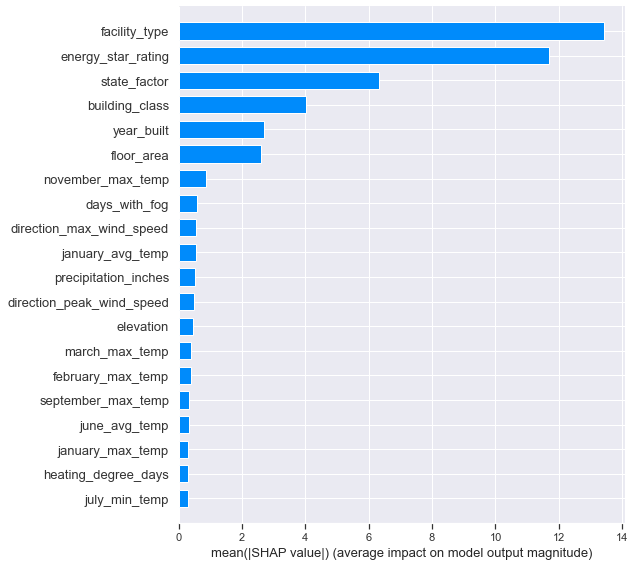

In [167]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

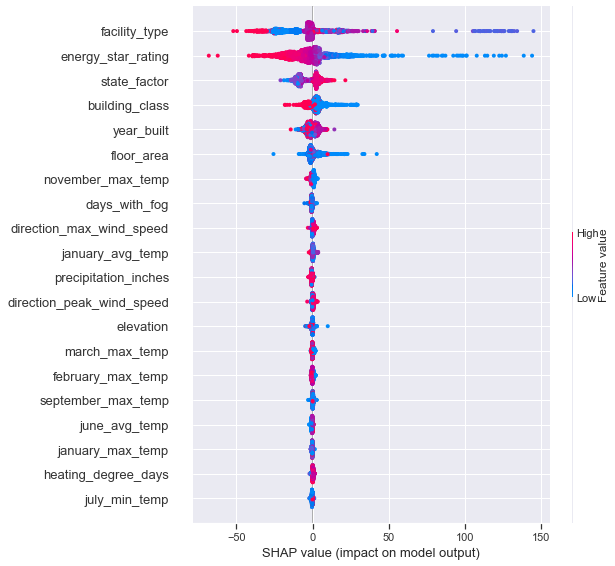

In [190]:
shap.summary_plot(shap_values, sample_set)

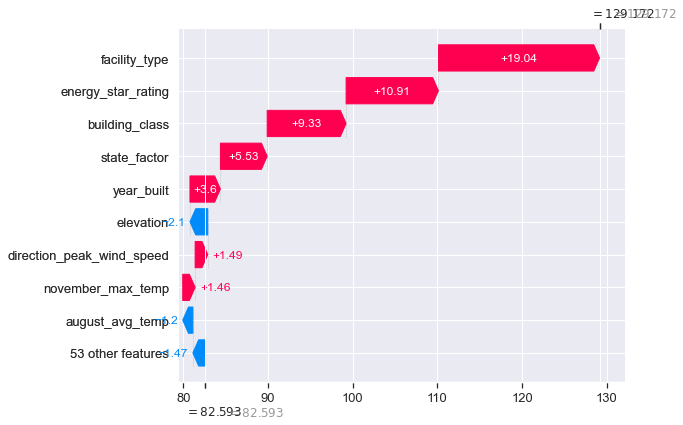

In [195]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

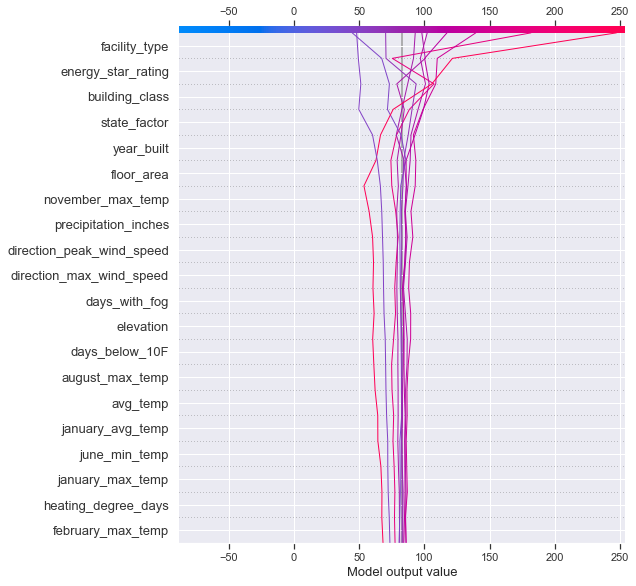

In [196]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

 99%|===================| 985/1000 [00:39<00:00]        

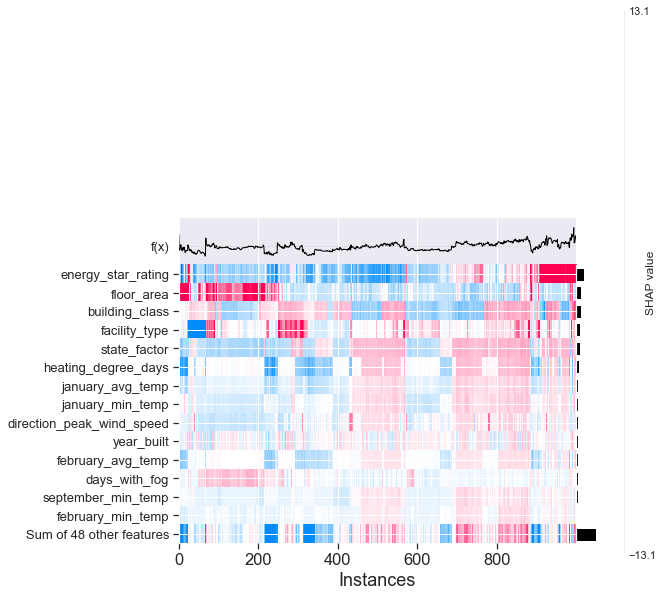

In [228]:
limit = 1000
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)